In [38]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

from __future__ import division

from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

import pydot


from scipy.stats import mode
from sklearn.ensemble.forest import _partition_estimators, _parallel_helper
from sklearn.tree._tree import DTYPE
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

# Functions

In [39]:
RanDomState=1000
def bool_attack(count):
    if count>0:
        return 1
    else:
        return 0

# Algorithme de machine learning

# Area compute by hand

In [40]:
dfAreaHand = pd.read_csv('../data/aden_golfe_matrix_area_hand.csv',sep=';')
dfAreaHand[dfAreaHand["Count"]>0].head()

,Area,Count,Fortnight,Month,Type,Years,Activity
730,AL,1,1,2,Vehicle Carrier,2008,2
814,AP,1,1,2,Other,2008,2
906,K,1,1,2,Tanker,2008,2
986,K,1,1,2,Tug,2008,2
1506,K,1,2,3,Vehicle Carrier,2008,2


## Pre-traitement

### Attack column

On créé une colonne pour savoir si il y a une attaque ou non.

In [41]:
dfAreaHand['Attack'] = dfAreaHand.apply(lambda row: bool_attack(row['Count']), axis=1)

### Binary

Le but de ce paragraphe est de transformer la colonne "Area" en colonnes binaire, c'est à dire de créer autant de colonnes que d'observations possibles

In [47]:
def binaryColumn(df,uniqueArea,uniqueType):
    
    featureBinary=[]

    for i in range(0,len(uniqueArea)):
        nameColArea='Area_'+str(uniqueArea[i])
        df[nameColArea]=0
        featureBinary.append(nameColArea)

    for i in range(0,len(uniqueType)):
        nameColType='Type_'+str(uniqueType[i])
        df[nameColType]=0
        featureBinary.append(nameColType)

    for index, row in df.iterrows():
        df.set_value(index, "Area_"+str(row['Area']),1)
        df.set_value(index, "Type_"+str(row['Type']),1)
    
    return df,featureBinary


uniqueArea=dfAreaHand["Area"].unique()
uniqueType=dfAreaHand["Type"].unique()

dfAreaHand,featureBinary=binaryColumn(dfAreaHand,uniqueArea,uniqueType)

print dfAreaHand["Type"].unique()

dfAreaHand["Area_new"] = dfAreaHand["Area"].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'AA': 27, 'AB': 28, 'AC': 29, 'AD': 30, 'AE': 31, 'AF': 32, 'AG': 33, 'AH': 34, 'AI': 35, 'AJ': 36, 'AK': 37, 'AL': 38, 'AM': 39, 'AN': 40, 'AO': 41, 'AP': 42, 'AQ': 43, 'AR': 44, 'AR': 45}).astype(int)
dfAreaHand["Type_new"] = dfAreaHand["Type"].map({'Vehicle Carrier': 1, 'Tanker': 2, 'Offshore Exploitation': 3, 'Other': 4, 'Tug': 5,'Vessel': 6, 'Barge': 7, 'Military': 8,'Ship':9}).astype(int)

dfAreaHand.head()

['Vehicle Carrier' 'Other' 'Tanker' 'Tug' 'Vessel' 'Barge'
 'Offshore Exploitation' 'Military' 'Ship']


,Area,Count,Fortnight,Month,Type,Years,Activity,Attack,Area_A,Area_AA,...,Type_Other,Type_Tanker,Type_Tug,Type_Vessel,Type_Barge,Type_Offshore Exploitation,Type_Military,Type_Ship,Area_new,Type_new
0,A,0,1,1,Vehicle Carrier,2008,2,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,AA,0,1,1,Vehicle Carrier,2008,2,0,0,1,...,0,0,0,0,0,0,0,0,27,1
2,AB,0,1,1,Vehicle Carrier,2008,2,0,0,0,...,0,0,0,0,0,0,0,0,28,1
3,AC,0,1,1,Vehicle Carrier,2008,2,0,0,0,...,0,0,0,0,0,0,0,0,29,1
4,AE,0,1,1,Vehicle Carrier,2008,2,0,0,0,...,0,0,0,0,0,0,0,0,31,1


In [48]:
features=['Activity','Fortnight','Month','Years']
features=np.concatenate([features,featureBinary]).tolist()
#features=np.concatenate([features,['Type_new','Area_new']]).tolist()

print features
target='Attack'

['Activity', 'Fortnight', 'Month', 'Years', 'Area_A', 'Area_AA', 'Area_AB', 'Area_AC', 'Area_AE', 'Area_AF', 'Area_AG', 'Area_AH', 'Area_AI', 'Area_AJ', 'Area_AL', 'Area_AM', 'Area_AN', 'Area_AO', 'Area_AP', 'Area_AQ', 'Area_AR', 'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'Area_G', 'Area_H', 'Area_I', 'Area_J', 'Area_K', 'Area_L', 'Area_M', 'Area_N', 'Area_O', 'Area_P', 'Area_R', 'Area_S', 'Area_T', 'Area_V', 'Area_W', 'Area_X', 'Area_Y', 'Area_Z', 'Type_Vehicle Carrier', 'Type_Other', 'Type_Tanker', 'Type_Tug', 'Type_Vessel', 'Type_Barge', 'Type_Offshore Exploitation', 'Type_Military', 'Type_Ship']


### Sampling 

In [49]:
Sampling=True

if Sampling:
    df_attack_raw = dfAreaHand[dfAreaHand[target] == 1]
    df_non_attack_raw = dfAreaHand[dfAreaHand[target] == 0]
    percentage = len(df_attack_raw)/float(len(df_non_attack_raw))
    print "pourcentage de ligne comportant des attaques : "+str(percentage*100)
    df_non_attack=dfAreaHand.sample(frac=percentage, random_state=1000)
    print str(len(df_non_attack))+'/'+str(len(df_non_attack_raw))

    DfSampling=df_non_attack.append(df_attack_raw)
    print len(DfSampling)
else:
    DfSampling=dfAreaHand

pourcentage de ligne comportant des attaques : 1.26243177176
764/59726
1518


# Machine learning

## Cross validation Random Forest

### N estimators

In [20]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 2000, 200)
for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print alpha

    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = RandomForestClassifier(random_state=1,n_estimators=alpha,n_jobs=4)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        print "----------------------------------------------------------"
        print i
        dfTrain=DfSampling[DfSampling['Years']<i]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = RandomForestClassifier(random_state=1,n_estimators=alpha,n_jobs=4)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    print score
    print score2
    
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
1
Nombre d'attaques prévus/Nombre d'attaques réel: 70/73
----------------------------------------------------------
2009
Nombre d'attaques prévus/Nombre d'attaques réel: 79/96
Pourcentage de précision : 0.575163398693
----------------------------------------------------------
2010
Nombre d'attaques prévus/Nombre d'attaques réel: 70/67
Pourcentage de précision : 0.675438596491
----------------------------------------------------------
2011
Nombre d'attaques prévus/Nombre d'attaques réel: 68/76
Pourcentage de précision : 0.611940298507
----------------------------------------------------------
2012
Nombre d'attaques prévus/Nombre d'attaques réel: 42/28
Pourcentage de précision : 0.575
----------------------------------------------------------
2013
Nombre d'attaques prévus/Nombre d'attaques réel: 14/9
Pourcentage d

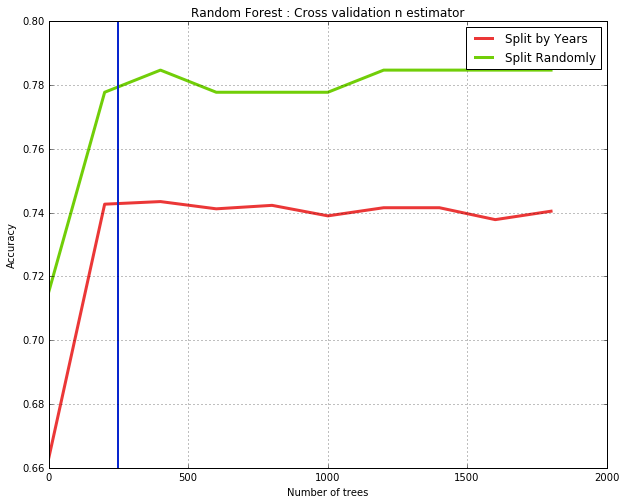

In [23]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=250,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Random Forest : Cross validation n estimator")
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

### max feature

In [240]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 15, 1)

for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print alpha
    
    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = RandomForestClassifier(random_state=1,max_features=alpha,n_jobs=4)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        print "----------------------------------------------------------"
        print i
        dfTrain=DfSampling[DfSampling['Years']<i]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = RandomForestClassifier(random_state=1,n_estimators=300,max_features=alpha,n_jobs=3)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    
    print score
    print score2
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
1
Nombre d'attaques prévus/Nombre d'attaques réel: 69/73
----------------------------------------------------------
2009
Nombre d'attaques prévus/Nombre d'attaques réel: 90/96
Pourcentage de précision : 0.738562091503
----------------------------------------------------------
2010
Nombre d'attaques prévus/Nombre d'attaques réel: 71/67
Pourcentage de précision : 0.719298245614
----------------------------------------------------------
2011
Nombre d'attaques prévus/Nombre d'attaques réel: 78/76
Pourcentage de précision : 0.686567164179
----------------------------------------------------------
2012
Nombre d'attaques prévus/Nombre d'attaques réel: 45/28
Pourcentage de précision : 0.6625
----------------------------------------------------------
2013
Nombre d'attaques prévus/Nombre d'attaques réel: 14/9
Pourcentage 

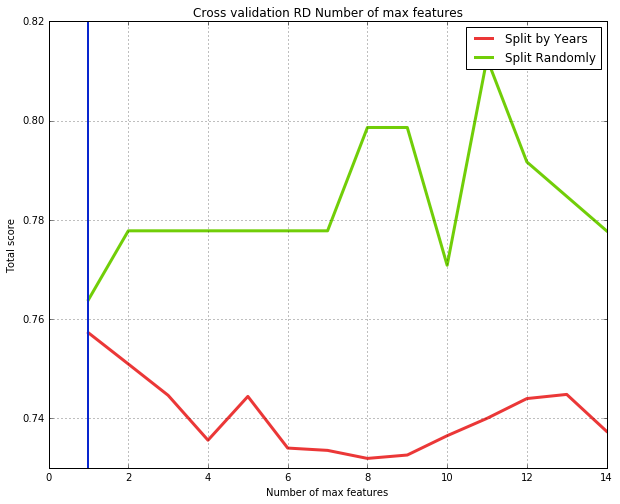

In [241]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=1,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Cross validation RD Number of max features")
plt.xlabel('Number of max features')
plt.ylabel('Total score')
plt.show()

## Best Random forest

In [59]:
years_prediction=2014
dfTrain=DfSampling[DfSampling['Years']<years_prediction]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]

print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['Count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['Count']!=0]))+'/'+str(len(dfTest))

 
Entrainement : Nombre d'attaques /nombre de ligne : 742/1395
Test : Nombre d'attaques /nombre de ligne : 16/123


In [60]:
model = RandomForestClassifier(random_state=1,n_estimators=250,max_features=1)
model=model.fit(dfTrain[features], dfTrain[target])

predictions=model.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))

print "Pourcentage de précision : "+str(model.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 11/16
Pourcentage de précision : 0.910569105691


In [61]:
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
Attack,,
0,0.971963,0.028037
1,0.500000,0.500000


In [62]:
pd.crosstab(dfTest[target],predictions, colnames=['preds'])

preds,0,1
Attack,,
0,104,3
1,8,8


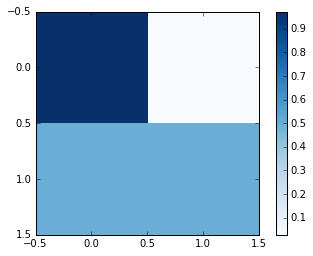

In [63]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

## Cross validation Gradient boosting

### N estimators

In [235]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 2000, 200)
for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print alpha

    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = GradientBoostingClassifier(random_state=1,n_estimators=alpha)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        print "----------------------------------------------------------"
        print i
        dfTrain=DfSampling[DfSampling['Years']<i]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = GradientBoostingClassifier(random_state=1,n_estimators=alpha)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    print score
    print score2
    
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
1
Nombre d'attaques prévus/Nombre d'attaques réel: 69/73
----------------------------------------------------------
2009
Nombre d'attaques prévus/Nombre d'attaques réel: 153/96
Pourcentage de précision : 0.627450980392
----------------------------------------------------------
2010
Nombre d'attaques prévus/Nombre d'attaques réel: 114/67
Pourcentage de précision : 0.587719298246
----------------------------------------------------------
2011
Nombre d'attaques prévus/Nombre d'attaques réel: 134/76
Pourcentage de précision : 0.567164179104
----------------------------------------------------------
2012
Nombre d'attaques prévus/Nombre d'attaques réel: 80/28
Pourcentage de précision : 0.35
----------------------------------------------------------
2013
Nombre d'attaques prévus/Nombre d'attaques réel: 63/9
Pourcentage

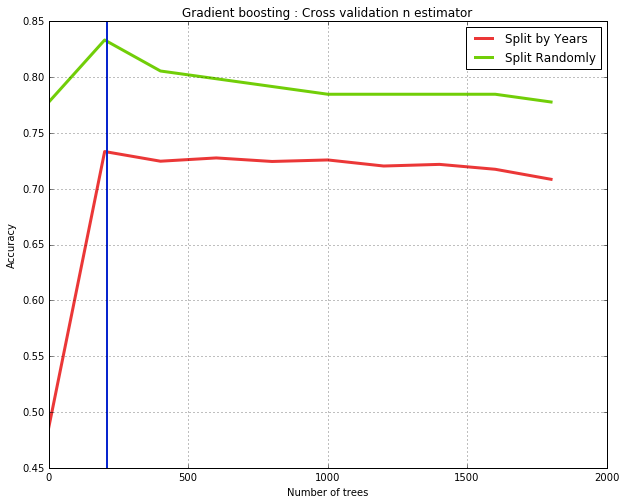

In [239]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=210,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Gradient boosting : Cross validation n estimator")
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

### Max features 

In [243]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 15, 1)

for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print "----------------------------------------------------------"
    print alpha
    
    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = GradientBoostingClassifier(random_state=1,max_features=alpha)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        print "----------------------------------------------------------"
        print i
        dfTrain=DfSampling[DfSampling['Years']<i]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = GradientBoostingClassifier(random_state=1,max_features=alpha)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    
    print score
    print score2
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
1
Nombre d'attaques prévus/Nombre d'attaques réel: 77/73
----------------------------------------------------------
2009
Nombre d'attaques prévus/Nombre d'attaques réel: 86/96
Pourcentage de précision : 0.699346405229
----------------------------------------------------------
2010
Nombre d'attaques prévus/Nombre d'attaques réel: 75/67
Pourcentage de précision : 0.719298245614
----------------------------------------------------------
2011
Nombre d'attaques prévus/Nombre d'attaques réel: 86/76
Pourcentage de précision : 0.731343283582
----------------------------------------------------------
2012
Nombre d'attaques prévus/Nombre d'attaques réel: 46/28
Pourcentage de précision : 0.675
----------------------------------------------------------
2013
Nombre d'attaques prévus/Nombre d'attaques réel: 15/9
Pourcentage d

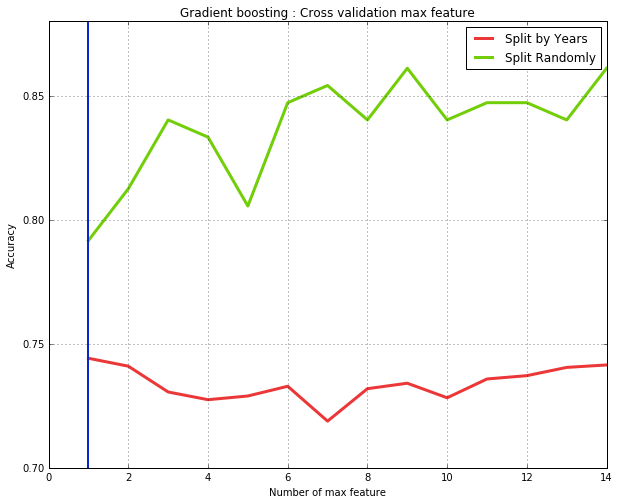

In [245]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=1,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Gradient boosting : Cross validation max feature")
plt.ylabel('Accuracy')
plt.xlabel('Number of max feature')
plt.show()


### Best Gradient Boosting

In [20]:
years_prediction=2012
dfTrain=DfSampling[DfSampling['Years']<years_prediction]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]

print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['Count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['Count']!=0]))+'/'+str(len(dfTest))

 
Entrainement : Nombre d'attaques /nombre de ligne : 452/745
Test : Nombre d'attaques /nombre de ligne : 56/116


In [21]:
model = GradientBoostingClassifier(random_state=1,n_estimators=200,max_features=1)
model=model.fit(dfTrain[features], dfTrain[target])

predictions=model.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))

print "Pourcentage de précision : "+str(model.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 73/56
Pourcentage de précision : 0.75


In [22]:
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
Attack,,
0,0.616667,0.383333
1,0.107143,0.892857


In [18]:
pd.crosstab(dfTest[target],predictions, colnames=['preds'])

preds,0,1
Attack,,
0,50,24
1,3,6


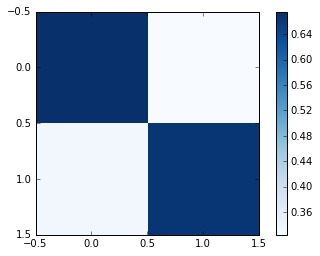

In [19]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Prediction 2015

In [34]:
def getPrediction(dfTrain,dfTest,features,target,nb_esti=250,nb_features=1):
    model = RandomForestClassifier(random_state=1,n_estimators=nb_esti,max_features=nb_features)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    probabilities=model.predict_proba(dfTest[features])[:, 1]
    return predictions,probabilities

In [35]:
size = len(dfAreaHand["Area"].unique())
ColYears= np.repeat(2015, size)
ColMonth = np.repeat(4, size)
ColFortnight = np.repeat(1, size)
ColType = np.repeat("Tanker", size)
ColActivity = np.repeat(1, size)
ColArea=dfAreaHand["Area"].unique()
       
dic = {'Years': ColYears,'Month': ColMonth,'Fortnight': ColFortnight, 'Area': ColArea,'Type':ColType,'Activity': ColActivity}
dfTest= pd.DataFrame(dic)
dfTest,featureBinary=binaryColumn(dfTest,uniqueArea,uniqueType)


In [36]:
prediction,probabilities=getPrediction(dfAreaHand,dfTest,features,target)
print prediction
print probabilities

[0 0 0 1 1 0 0 0 0 0 0 1 0]
[ 0.012  0.016  0.     0.652  0.616  0.016  0.008  0.     0.004  0.008
  0.016  0.644  0.   ]
